# Mass fractions optimization using AixNet and Sybill 2.3c

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mass_fractions import *
from simulated_dipole import *


dd = np.load('simulated_data.npy', allow_pickle=True).item()
print(dd.keys())

dd['charge'] = np.empty_like(dd['mass'])
dd['charge'][np.where(dd['mass']==1)] = 1
dd['charge'][np.where(dd['mass']==4)] = 2
dd['charge'][np.where(dd['mass']==16)] = 8
dd['charge'][np.where(dd['mass']==56)] = 26

print(dd['charge'])
print(len(dd['charge']))
print(dd['element'])
generate_xmax19(dd, 'dnn_xmax', 'energy')

dict_keys(['dnn_axis', 'dnn_core', 'dnn_energy', 'dnn_xmax', 'event_id', 'auger_id', 'sd_id', 'is_saturated', 'core', 'axis', 'energy', 'xmax', 'element', 'mass', 'merit', 'fd_energy', 'fd_axis', 'sd_energy', 'sd_axis', 'sd_galactic_latitude', 'sd_galactic_longitude', 'sd_core', 'univ_energy', 'univ_axis', 'delta_mean_delta', 'delta_xmax', 'delta_energy', 'muon_number'])
[ 1.  1.  1. ... 26. 26. 26.]
32647
[b'Proton' b'Proton' b'Proton' ... b'Iron' b'Iron' b'Iron']


[1918 1794 1630 1902 1750 1838 1824 1880 1780 1911 1814 1754]
{'x': array([0.52083333, 0.5625    , 0.60416667, 0.64583333, 0.6875    ,
       0.72916667, 0.77083333, 0.8125    , 0.85416667, 0.89583333,
       0.9375    , 0.97916667]), 'y': array([1.0022376 , 1.0029383 , 0.9999275 , 1.0049087 , 1.000909  ,
       0.9956084 , 0.9984114 , 1.000286  , 1.0008706 , 0.9984486 ,
       0.9973571 , 0.99809813], dtype=float32), 'std_y': array([0.05854079, 0.059586  , 0.0583445 , 0.0576755 , 0.05451107,
       0.05486856, 0.0576058 , 0.055562  , 0.05649057, 0.05532103,
       0.05375691, 0.05332116], dtype=float32), 'n': array([1918, 1794, 1630, 1902, 1750, 1838, 1824, 1880, 1780, 1911, 1814,
       1754])}


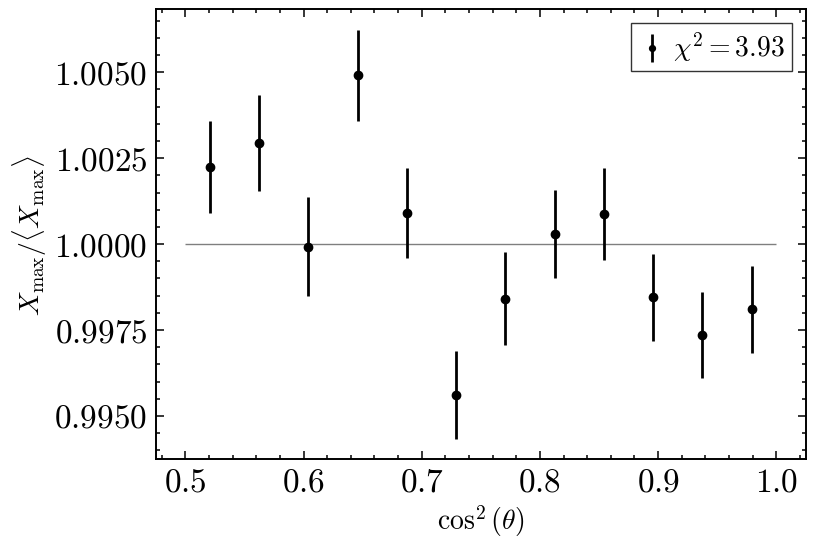

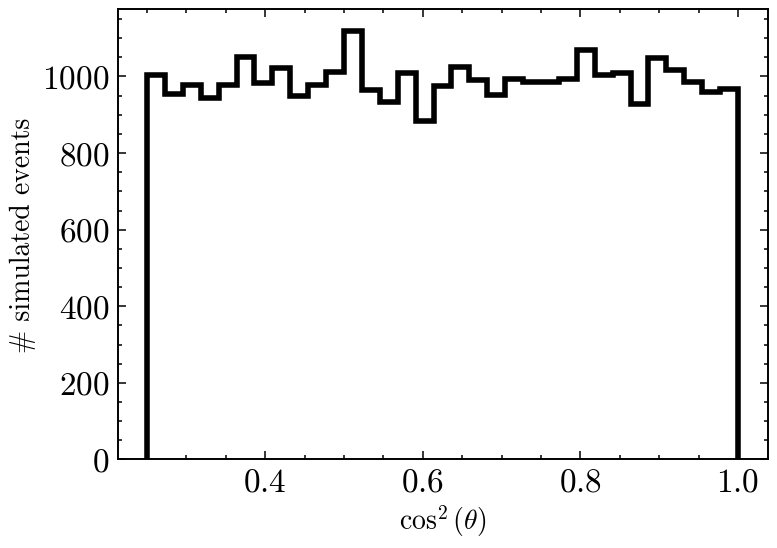

In [14]:
# zenith distribution
n_bins = 12 
bins = np.linspace(0.5, 1, n_bins+1)
# print(bins)
bin_idx = np.digitize(dd['axis'][:, 2]**2, bins)-1
bin_centers = (bins[1:]+bins[:-1])/2
y_means = np.array([dd['dnn_xmax'][bin_idx == i].mean() for i in range(n_bins)])
y_std = np.array([dd['dnn_xmax'][bin_idx == i].std() for i in range(n_bins)])
n_points = np.array([np.sum(bin_idx == i) for i in range(n_bins)])
y_se = y_std / np.sqrt(n_points)
print(n_points)
val = {
    'x': bin_centers,
    'y': y_means/np.mean(y_means),
    'std_y': y_std/np.mean(y_means),
    'n': n_points
}
print(val)

valid = val["n"] > 1
null_chisq = [((val["y"][valid][i]-1)/(val["std_y"][valid][i] / val["n"][valid][i]**0.5))**2 for i in range(len(val["x"][valid]))]
null_chisq = np.sum(null_chisq)/(len(val["x"][valid])-1)

plt.figure(figsize=(10, 6))
plt.errorbar(val['x'], val['y'], yerr=(val['std_y']/np.sqrt(n_points)), linestyle='', marker='o', markersize=6, color='k', ecolor='k', lw=2, label=rf'$\chi^2 = {null_chisq:.2f}$')
plt.hlines(1, np.min(bins), np.max(bins), color="k", linewidth=1, alpha=0.5)
plt.legend()
plt.xlabel(r'$\cos^2(\theta)$')
plt.ylabel(r'$X_\mathrm{max}/\langle X_\mathrm{max} \rangle$')
plt.show()


plt.figure(figsize=(10,6))
plt.hist(dd['axis'][:, 2]**2, color='k', histtype='step', lw=4)
plt.xlabel(r'$\cos^2(\theta)$')
plt.ylabel(r'# simulated events')
plt.show()


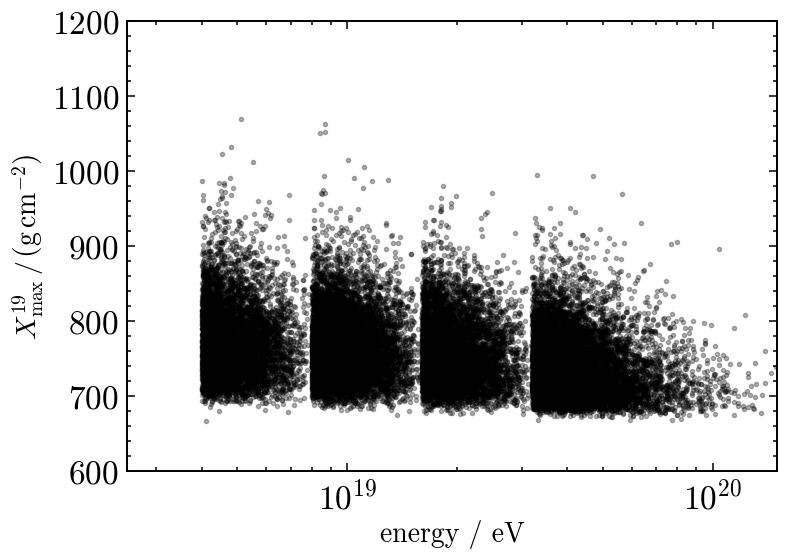

In [15]:
plt.figure(figsize=(10,6))
# plt.title('Comic Sans!!!')
# plt.title(rf'Simulated data, $n_\mathrm{{data}}={len(dd['energy'])}$')
plt.scatter(dd['energy']*1e18, dd['xmax19'], alpha=0.3, color='k')
plt.xlabel(r'energy / eV')
plt.ylabel(r'$X^{19}_\mathrm{max} \, / \, \mathrm{\left(g \, cm^{-2}\right)}$')
plt.xscale('log')
plt.ylim(600, 1200)
plt.xlim(2.5e18, 150e18)
plt.show()


### Defining bins

In [16]:
smd = SMD_method()

thres_values = np.linspace(np.min(dd['xmax19']), np.max(dd['xmax19']), 42)
# print(thres_values)
results_dict = {'emin': [], 
                'emax': [], 
                'light': [], 
                'heavy': [], 
                'N_light': [],
                'N_heavy': [],
                'N_tot': [],
                'SMD': [], 
                'lnA_light': [],
                'lnA_heavy': []
                }


# histo, bin_edge = np.histogram(dd['xmax19'], bins=71)
# bins = (bin_edge[1:]+bin_edge[:-1])/2
# plt.figure(figsize=(10,6))
# for ttt in thres_values:
#     plt.axvline(ttt, lw=2, color='grey', ls='-.', alpha=0.5)
# plt.fill_between(bins[bins<thres_values[4]], 0, histo[bins<thres_values[4]], color='steelblue', alpha=0.5, label='heavy subset')
# plt.fill_between(bins[bins>thres_values[11]], 0, histo[bins>thres_values[11]], color='firebrick', alpha=0.5, label='light subset')
# plt.axvline(thres_values[4], lw=4, color='steelblue', ls='-.')
# plt.axvline(thres_values[11], lw=4, color='firebrick', ls='-.')
# plt.hist(dd['xmax19'], color='k', histtype='step', lw=4)
# plt.xlabel(r'$X^{19}_\mathrm{max} \, / \, \mathrm{\left(g \, cm^{-2}\right)}$')
# plt.ylabel(r'# simulated events')
# plt.legend()
# plt.show()

print(len(dd['energy'][dd['energy']>8]))

25805


### Evaluating best fractions - $X_\mathrm{max}^{19}$

In [17]:
for ee in range(1, len(energies)-1):
    e_min = energies[ee]/1e18
    e_max =energies[ee+1]/1e18

    e_mask = (dd['energy']<e_max)&(dd['energy']>=e_min)
    data = dict_cutter(dd, e_mask)
    print(e_min, 'n=', len(data['sd_id']))

    for i in range(1, len(thres_values) - 2):
        thres_h = thres_values[i]

        for j in range(i + 1, len(thres_values) - 1):

            thres_l = thres_values[j]
            mask_h = (data['xmax19']<thres_h)
            mask_l = (data['xmax19']>thres_l)
            light_frac = dict_cutter(data, mask_l)
            heavy_frac = dict_cutter(data, mask_h)

            value = smd.quantify_SMD(light_frac['energy'], light_frac['charge'], heavy_frac['energy'], heavy_frac['charge'], d_max=1)
            A_l = np.sum(np.log(light_frac['mass']))
            A_h = np.sum(np.log(heavy_frac['mass']))

            results_dict['emin'].append(e_min)
            results_dict['emax'].append(e_max)
            results_dict['light'].append(thres_l)
            results_dict['heavy'].append(thres_h)
            results_dict['SMD'].append(value)
            results_dict['N_light'].append(len(light_frac['xmax19']))
            results_dict['N_heavy'].append(len(heavy_frac['xmax19']))
            results_dict['N_tot'].append(len(data['xmax19']))
            results_dict['lnA_light'].append(A_l/len(data['xmax19']))
            results_dict['lnA_heavy'].append(A_h/len(data['xmax19']))
            # print(thres_h, thres_l, value)

8.0 n= 8662
16.0 n= 7141
32.0 n= 10002


### Plotting

/tmp/ipykernel_41513/2008320090.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(dot_x+15, dot_y, rf'$({float(dot_x):.0f},{float(dot_y):.0f}) \, \mathrm{{g \, cm^{{-2}}}}$')


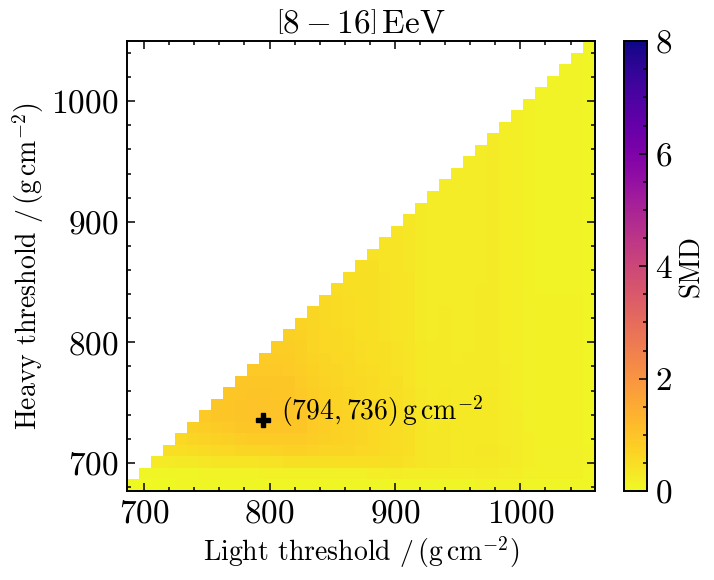

light fraction: [0.23955207] lnA: [0.34009188]
heavy fraction: [0.24971138] lnA: [0.5857019]


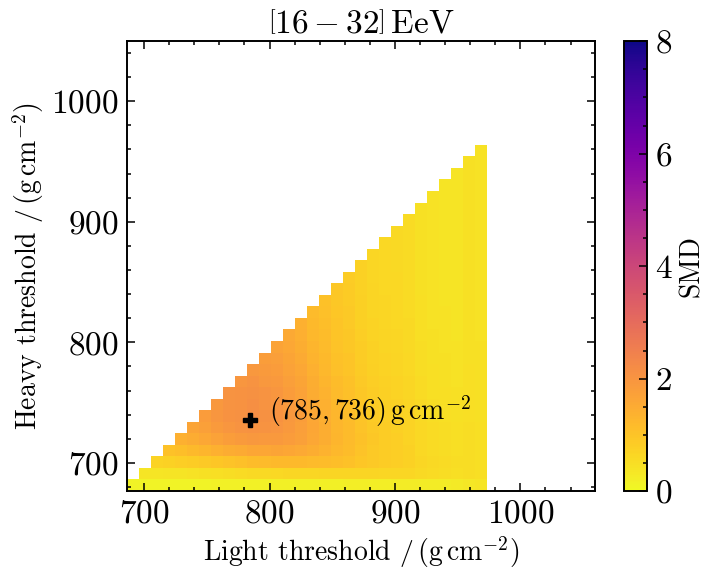

light fraction: [0.25290576] lnA: [0.4223558]
heavy fraction: [0.33020585] lnA: [0.864874]


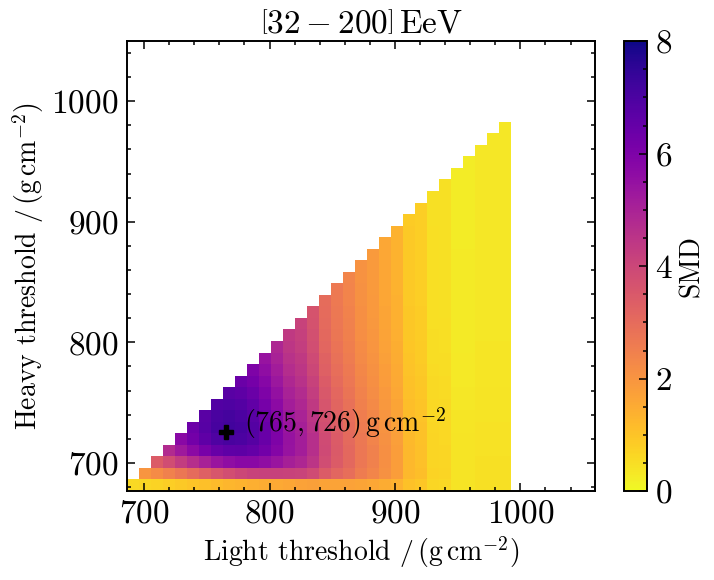

light fraction: [0.24255149] lnA: [0.48819602]
heavy fraction: [0.43591282] lnA: [1.5185539]


In [18]:
for key, value in results_dict.items():
    results_dict[key] = np.array(value)

for i in range(1, len(energies[:-1])):
    ene = energies[i]
    eneplus = energies[i+1]
    light_vals = np.array(results_dict['light'][results_dict['emin']==ene/1e18])
    heavy_vals = np.array(results_dict['heavy'][results_dict['emin']==ene/1e18])
    SMD_vals = np.array(results_dict['SMD'][results_dict['emin']==ene/1e18])
    # Create grid
    unique_light = np.unique(light_vals)  # Unique x values
    unique_heavy = np.unique(heavy_vals)  # Unique y values

    # Reshape SMD values into a 2D array
    SMD_grid = np.zeros((len(unique_heavy), len(unique_light)))

    for i, h in enumerate(unique_heavy):
        for j, l in enumerate(unique_light):
            mask = (heavy_vals == h) & (light_vals == l)
            if np.any(mask):
                SMD_grid[i, j] = SMD_vals[mask][0]  # Take first match

    masked_SMD = np.ma.masked_where((unique_light[None, :] <= unique_heavy[:, None])|(SMD_grid<=0), SMD_grid)
    # heatmap with absolute value
    plt.figure(figsize=(9, 6))
    plt.title(rf'$\left[{ene/1e18:.0f}-{eneplus/1e18:.0f} \right] \, \mathrm{{EeV}}$')
    cmap = plt.cm.plasma_r.copy()
    cmap.set_bad(color='white')  # Set masked values to white

    plt.imshow(masked_SMD, aspect='auto', origin='lower',
            extent=[unique_light.min(), unique_light.max(),
                    unique_heavy.min(), unique_heavy.max()],
            cmap=cmap, vmin=0, vmax=8)
    dot_x = (unique_light[np.where(SMD_grid==SMD_grid.max())[1]])
    dot_y =  (unique_heavy[np.where(SMD_grid==SMD_grid.max())[0]])
    plt.text(dot_x+15, dot_y, rf'$({float(dot_x):.0f},{float(dot_y):.0f}) \, \mathrm{{g \, cm^{{-2}}}}$')
    plt.plot(dot_x, dot_y, ls='', marker='P', color='k', markersize=10)
    plt.colorbar(label='SMD')
    plt.xlabel(r'Light threshold $/ \, \mathrm{(g \, cm^{-2})}$')
    plt.ylabel(r'Heavy threshold $/ \, \mathrm{(g \, cm^{-2})}$')
    # plt.grid()

    xticks = np.arange(700, 1050, 100)  
    plt.xticks(xticks)
    plt.show()

    best_pos = np.where((results_dict['light']==dot_x)&(results_dict['heavy']==dot_y)&(results_dict['emin']==ene/1e18))
    print('light fraction:', results_dict['N_light'][best_pos]/results_dict['N_tot'][best_pos], 'lnA:', results_dict['lnA_light'][best_pos])
    print('heavy fraction:', results_dict['N_heavy'][best_pos]/results_dict['N_tot'][best_pos], 'lnA:', results_dict['lnA_heavy'][best_pos])

    